Convolutional Neural Network (CNN) 
Multi-Layer Perceptron (MLP)

In [2]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

import tensorflow as tf
import keras

import os

2023-03-13 02:02:44.683347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the data

#### Description of the data: 
There are  labeled subsets of the 80 million tiny images dataset and consists of 60000 **32x32** RGB images in 10 classes, with 6000 images per class. There are **50000 training images** and **10000 test images**. Source: https://www.cs.toronto.edu/~kriz/cifar.html

The data can be directly downloaded with Keras.

In [ ]:
from keras.datasets import cifar10
from keras import backend as K

In [ ]:
K.set_image_data_format('channels_last')
(x_train_original, y_train_original), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train_original.shape)
print(x_train_original.shape[0], 'train samples')
print(y_train_original.shape, 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
(50000, 1) train samples
10000 test samples


In [ ]:
num_classes = y_train_original.max() +1
num_classes

10

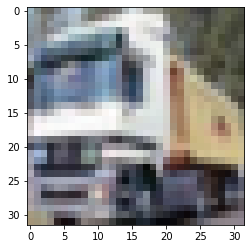

In [ ]:
plt.imshow(x_train_original[1])

In [ ]:
y_train_original

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
LABELS = {
    0 : "airplane", 
    1 : "automobile", 
    2 : "bird", 
    3 : "cat", 
    4 : "deer",           
    5 : "dog", 
    6 : "frog",
    7 : "horse", 
    8 : "ship",
    9 : "truck"
}

Preprocess the data

- Data cleaning
- Data conversion
- Data normalization
- Data split

#### Data split

Split: Train 40000, Val 10000, Test 10000.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_original, y_train_original, test_size=10000, random_state=42, shuffle= True,stratify=y_train_original)

Check:

In [ ]:
x_train.shape

(40000, 32, 32, 3)

In [ ]:
x_val.shape

(10000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
from collections import Counter

In [ ]:
Counter(list(y_train.reshape(-1)))


Counter({0: 4000,
         1: 4000,
         2: 4000,
         3: 4000,
         4: 4000,
         5: 4000,
         6: 4000,
         7: 4000,
         8: 4000,
         9: 4000})

In [ ]:
Counter(list(y_test.reshape(-1)))


Counter({0: 1000,
         1: 1000,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 1000,
         7: 1000,
         8: 1000,
         9: 1000})

#### Convert class vectors to binary class matrices. (one-hot encoding)

The output layer of the neural network contains as many neurons as there are classes. For a given sample, each output neuron gives the probability to belong to the corresponding class.
The ground-truth labels need to be formated in the same way such as for each sample, we have a vector of shape the number of classes: i.e., ${y}_{i,k}=1$ when the $i$-th sample belongs to the class $k$, or $0$ otherwise. Note that $\sum_{k=1}^K{y}_{i,k}=1$.

This will help the comparison in the loss function:
$L=\sum_{i=1}^N \sum_{k=1}^K \left( -y_{i,k}\log\hat{y}_{i,k} \right)$ where ${y}_{i,k}$ is the indicator of the true class, $\hat{y}_{i,k}$ is the probability that the $i$-th sample belongs to the class $k$, $N$ and $K$ are respectively the number of samples in the training set and the number of classes




In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_original.shape

(50000, 1)

In [ ]:
y_train_original = to_categorical(y_train_original, num_classes)
y_test = to_categorical(y_test, num_classes)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [ ]:
y_train_original.shape

(50000, 10)

#### Normalize the data

Here, the MinMax scaling is used : $\frac{x-\min(x)}{\max(x)-\min(x)}$  
The images are just divided by the maximun value of a pixel because the minimum is 0.

In [ ]:
# The data must be converted into float in order to normalize them.
x_train_original = x_train_original.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

x_train_original /= 255
x_test /= 255
x_train /= 255
x_val /= 255

In [ ]:
from tensorflow.keras.models import Model,Sequential

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D

### CNN - finetuning

In [ ]:
model_CNN = Sequential()
model_CNN.add(Conv2D(filters = 32, kernel_size= (3, 3), padding='same', strides=(1, 1),
                 input_shape=x_train.shape[1:]))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(32, (3, 3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(64, (3, 3), padding='same'))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(64, (3, 3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.3))

model_CNN.add(Conv2D(filters = 128, kernel_size= (3, 3), padding='same', strides=(1, 1), #add another block
                 input_shape=x_train.shape[1:]))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(128, (3, 3)))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.6))

model_CNN.add(Flatten())
model_CNN.add(Dense(512))
model_CNN.add(BatchNormalization()) #regularization on the fully connected network
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes))
model_CNN.add(Activation('softmax'))

#### Train the model

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
opt = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_CNN.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [ ]:
batch_size = 64
epochs = 50
hist_CNN = model_CNN.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,callbacks=[es])

Epoch 1/50
625/625 [==============================] - 25s 33ms/step - loss: 1.9020 - accuracy: 0.2684 - val_loss: 1.6238 - val_accuracy: 0.4247
Epoch 2/50
625/625 [==============================] - 15s 24ms/step - loss: 1.5645 - accuracy: 0.4155 - val_loss: 1.3855 - val_accuracy: 0.4914
Epoch 3/50
625/625 [==============================] - 14s 22ms/step - loss: 1.4238 - accuracy: 0.4771 - val_loss: 1.2543 - val_accuracy: 0.5384
Epoch 4/50
625/625 [==============================] - 17s 27ms/step - loss: 1.3189 - accuracy: 0.5225 - val_loss: 1.2071 - val_accuracy: 0.5575
Epoch 5/50
625/625 [==============================] - 19s 31ms/step - loss: 1.2307 - accuracy: 0.5586 - val_loss: 1.0647 - val_accuracy: 0.6183
Epoch 6/50
625/625 [==============================] - 21s 33ms/step - loss: 1.1513 - accuracy: 0.5915 - val_loss: 1.0749 - val_accuracy: 0.6162
Epoch 7/50
625/625 [==============================] - 20s 32ms/step - loss: 1.0710 - accuracy: 0.6197 - val_loss: 0.9058 - val_accuracy:

In [ ]:
model_CNN.predict(x_test)[0]

array([3.13465061e-05, 5.56654231e-06, 5.87371935e-04, 9.71399844e-01,
       1.06302876e-04, 2.58048140e-02, 1.79288466e-03, 2.29478712e-04,
       3.30657822e-05, 9.32729199e-06], dtype=float32)

One trick to improve the CNN model is to use **data augmentation**. It works by adding a small pertubation to the input data (flipping, rotation, noise...). It acts as a regularizer and helps reduce overfitting. It is also a way to increase the number of examples.

The object ImageDataGenerator and the method fit_generator have to be used.

In [ ]:
import keras

datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    fill_mode='nearest', # set mode for filling points outside the input boundaries
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    validation_split=0.0)

In [ ]:
%%time
batch_size = 64
epochs = 70
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
hist_CNN = model_CNN.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    workers=4,callbacks=[es])

Epoch 1/70
625/625 [==============================] - 23s 37ms/step - loss: 0.5870 - accuracy: 0.8018 - val_loss: 0.5572 - val_accuracy: 0.8009
Epoch 2/70
625/625 [==============================] - 23s 37ms/step - loss: 0.5782 - accuracy: 0.8012 - val_loss: 0.5004 - val_accuracy: 0.8212
Epoch 3/70
625/625 [==============================] - 23s 37ms/step - loss: 0.5806 - accuracy: 0.8040 - val_loss: 0.4932 - val_accuracy: 0.8259
Epoch 4/70
625/625 [==============================] - 23s 36ms/step - loss: 0.5786 - accuracy: 0.8032 - val_loss: 0.5156 - val_accuracy: 0.8159
Epoch 5/70
625/625 [==============================] - 23s 37ms/step - loss: 0.5773 - accuracy: 0.8039 - val_loss: 0.5323 - val_accuracy: 0.8112
Epoch 6/70
625/625 [==============================] - 23s 37ms/step - loss: 0.5687 - accuracy: 0.8064 - val_loss: 0.4985 - val_accuracy: 0.8220
Epoch 7/70
625/625 [==============================] - 24s 38ms/step - loss: 0.5700 - accuracy: 0.8083 - val_loss: 0.4944 - val_accuracy:

#### Analyse the results

In [ ]:
hist_CNN.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

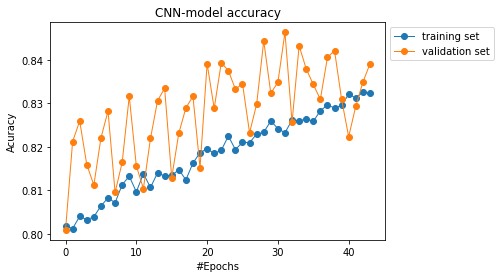

In [ ]:
plt.plot(hist_CNN.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_CNN.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

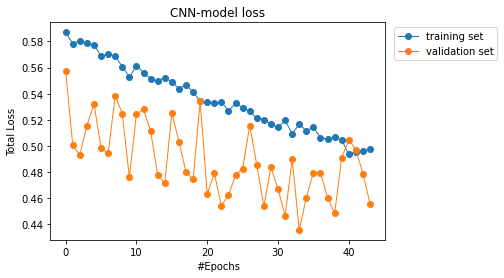

In [ ]:
plt.plot(hist_CNN.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_CNN.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

I got a final accuracy on the validation set of 0.86.

### MLP (Sequence API)

Main functions:

layers.Dense(units,...): units correspond to the number of neurons of the layer;
layers.BatchNormalization(): normalize the pre-activations;
layers.ReLU(): computes the activation function ReLU;
layers.Dropout(): regularization technique - some units are hidden during the training phase. They are chosen randomly at each train step.

In [ ]:
clear_session()

In [ ]:
model_MLP = Sequential()

model_MLP.add(Flatten(input_shape=(32, 32, 3)))

model_MLP.add(Dense(128,input_shape=(3072,))) 
model_MLP.add(BatchNormalization())
model_MLP.add(ReLU())
model_MLP.add(Dropout(0.25))

model_MLP.add(Dense(64)) 
model_MLP.add(BatchNormalization())
model_MLP.add(ReLU())
model_MLP.add(Dropout(0.25))

model_MLP.add(Dense(num_classes, activation='softmax'))

model_MLP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)               

#### Train the model

In [ ]:
opt = Adam(lr=0.001)

In [ ]:
model_MLP.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [ ]:
%%time 
batch_size = 64
epochs = 50
#Theses hyperparameters can be declared in a same block with N_HIDDEN_NODES...

hist_MLP = model_MLP.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=[es])

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 1.8652 - accuracy: 0.3353 - val_loss: 2.0044 - val_accuracy: 0.2736
Epoch 2/50
625/625 [==============================] - 2s 4ms/step - loss: 1.6637 - accuracy: 0.4030 - val_loss: 1.6516 - val_accuracy: 0.4147
Epoch 3/50
625/625 [==============================] - 2s 4ms/step - loss: 1.5883 - accuracy: 0.4311 - val_loss: 1.5638 - val_accuracy: 0.4490
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 1.5399 - accuracy: 0.4482 - val_loss: 1.5611 - val_accuracy: 0.4377
Epoch 5/50
625/625 [==============================] - 2s 4ms/step - loss: 1.5061 - accuracy: 0.4601 - val_loss: 1.6310 - val_accuracy: 0.4134
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 1.4737 - accuracy: 0.4739 - val_loss: 1.6343 - val_accuracy: 0.4193
Epoch 7/50
625/625 [==============================] - 2s 4ms/step - loss: 1.4504 - accuracy: 0.4809 - val_loss: 1.4956 - val_accuracy: 0.4761
Epoch 

#### Analyse the results

In [ ]:
hist_MLP.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

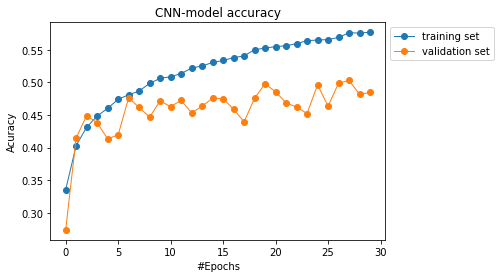

In [ ]:
plt.plot(hist_MLP.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_MLP.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

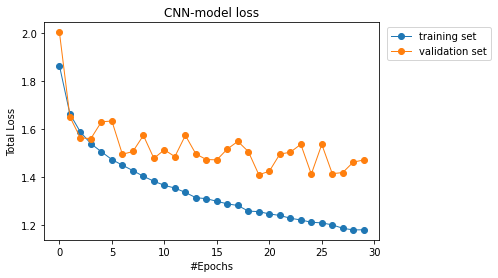

In [ ]:
plt.plot(hist_MLP.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_MLP.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

#### Compute the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model_CNN.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_pred = [LABELS[y_]for y_ in y_pred]
y_pred

In [ ]:
y_true = np.argmax(y_val, axis=1)
y_true = [LABELS[y_] for y_ in y_true]
y_true

In [ ]:
cm = confusion_matrix(y_true=y_true,y_pred=y_pred,labels=list(LABELS.values()))
cm

In [ ]:
disp = ConfusionMatrixDisplay(cm,display_labels=list(LABELS.values()))
disp.plot()

### Compare MLP and CNN

##### Evaluate the two models on the final test set

Configure them with the best combination of hyperparameters and change only this fonction:

In [ ]:
model.fit(x=X_train_original,y=y_train_original,
                  epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,
                  class_weight=class_weights,
                  shuffle=True,
                  validation_data=(x_test, y_test))

Train a last time on the entire training set (validation set included) and evaluate the model on the test set

In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

##### Which model is the best ?

It is clear that the CNN achieved the best results.